# Example: Gaussian with Given Variance

As a model we are given a univariate Gaussian distribution with unknown mean
and standard deviation σ = 1. We have one data point at 2.0. For this
toy example, we can compute the posterior over the mean. But to illustrate
likelihood-free inference, let us assume here that we can only sample from the
model:

In [1]:
using LikelihoodfreeInference, Distributions, Random
model(x) = randn() .+ x

model (generic function with 1 method)

LikelihoodfreeInference.jl passes parameter values as vectors to the model,
even in the one-dimensional case. In our definition of the model we assume
that `x[1]` is the mean.

## Approximate the Posterior
Our first goal is to find the posterior over the mean given observation and
a Gaussian prior with mean 0 and standard deviation 5.

In [2]:
data = [2.0]
prior = MultivariateNormal([0.], [5.])

DiagNormal(
dim: 1
μ: [0.0]
Σ: [25.0]
)


The true posterior is a Gaussian distribution with mean 25/26*2 and standard
deviation 26/25

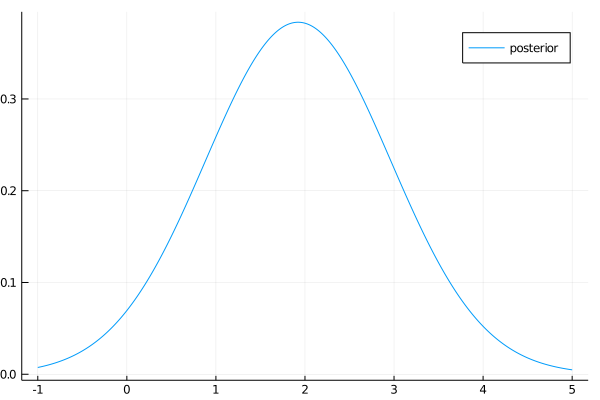

In [3]:
trueposterior = pdf.(Normal.(-1:.01:5, 26/25), 25/26*2.0)
using Plots
gr()
figure = plot(-1:.01:5, trueposterior, label = "posterior")

Now, we will use an adaptive sequential Monte Carlo method:

In [4]:
smc = AdaptiveSMC(prior = prior, K = 10^4)
result = run!(smc, model, data, verbose = true, maxfevals = 10^6);

 iteration       elapsed   fevals  epsilon      ess
         0     0 seconds    10000      Inf        1
         1      1 second    19000 9.068356e+00 0.8999999999999998
         2      1 second    27101 7.240516e+00 0.8101000000000006
         3      1 second    34392 6.059302e+00 0.7291000000000006
         4     2 seconds    40954 5.258510e+00 0.6561999999999997
         5     2 seconds    46860 4.599358e+00   0.5906
         6     2 seconds    52176 4.038250e+00   0.5316
Resampling...
         7     2 seconds    62176 3.568297e+00 0.9999999999999998
         8     2 seconds    71176 3.163881e+00 0.8999999999999997
         9     2 seconds    79277 2.819687e+00 0.8101000000000007
        10     2 seconds    86568 2.507539e+00 0.7291000000000007
        11     3 seconds    93130 2.247536e+00 0.6561999999999997
        12     3 seconds    99036 2.022443e+00   0.5906
        13     3 seconds   104352 1.810461e+00   0.5316
Resampling...
        14     3 seconds   114352 1.641814e+00 0.9

As a Monte Carlo Method the result is a list of particles

In [5]:
particles(smc)

10000-element Array{Array{Float64,1},1}:
 [0.8975150060425441]
 [1.0514855625752062]
 [1.3066655317770741]
 [2.523275997549325]
 [1.7498870979627128]
 [2.094919594580396]
 [1.8376509691904683]
 [1.5871100191382472]
 [2.163815644335987]
 [0.13509403535620468]
 ⋮
 [2.3969210170817683]
 [0.9417283125290146]
 [1.5463942101402754]
 [2.6378026555706473]
 [2.1992513424462077]
 [1.953762845409608]
 [2.908034099686952]
 [0.9777839913151236]
 [1.4493001312800997]

with corresponding weights

In [6]:
weights(smc)

10000-element Array{Float64,1}:
 0.0
 0.00018677624206200972
 0.0
 0.00018677624206200972
 0.0
 0.00018677624206200972
 0.0
 0.00018677624206200972
 0.0
 0.00018677624206200972
 ⋮
 0.00018677624206200972
 0.0
 0.0
 0.0
 0.0
 0.0
 0.00018677624206200972
 0.00018677624206200972
 0.00018677624206200972

The mean of the posterior is given by `weights(smc) .* particles(smc)`, which
is computed by the `mean` function.

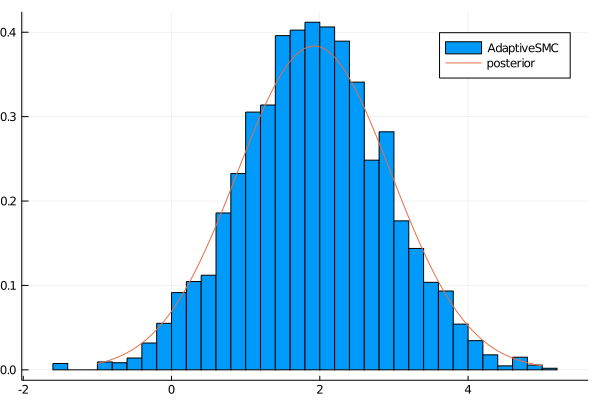

In [7]:
mean(smc)

figure = histogram(vcat(particles(smc)...), weights = weights(smc), normalize = true, label = "AdaptiveSMC")
plot!(figure, -1:.01:5, trueposterior, label = "posterior")

The `result` above also contains these weights and particles and some
additional information.

In [8]:
keys(result)

(:weights, :particles, :n_sims, :epsilons)

AdaptiveSMC reduced the epsilon parameter adaptively, as we saw in column
epsilon of the run above. We can plot this sequence.

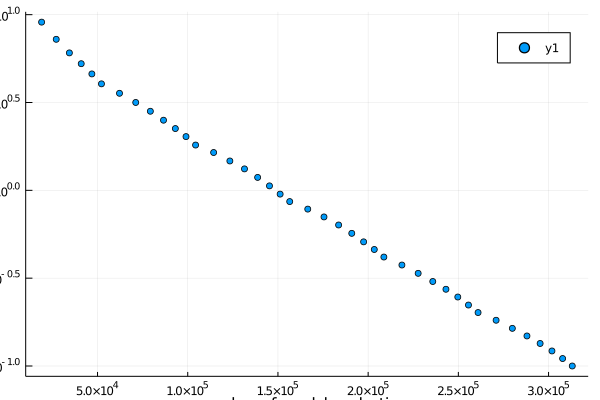

In [9]:
scatter(cumsum(result.n_sims)[2:end], result.epsilons,
        yscale = :log10, ylabel = "epsilon", xlabel = "number of model evaluations")

Alternatively, we may want to use KernelABC.

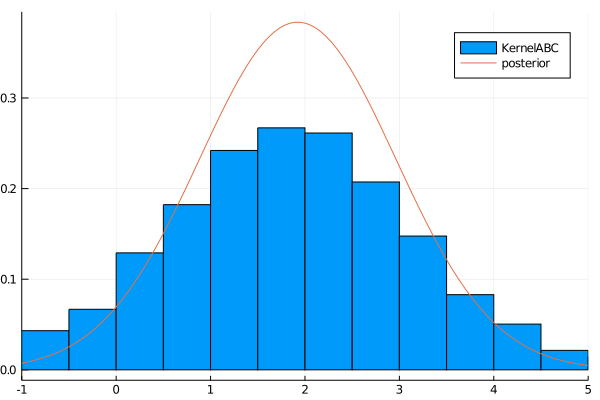

In [10]:
kabc = KernelABC(prior = prior,
                 kernel = Kernel(),
                 delta = 1e-12,
                 K = 10^4)
result = run!(kabc, model, data, maxfevals = 10^4)
mean(kabc)

figure = histogram(vcat(particles(kabc)...), weights = weights(kabc),
                   xlims = (-1, 5), bins = 100,
                   normalize = true, label = "KernelABC")
plot!(figure, -1:.01:5, trueposterior, label = "posterior")

## Point Estimates
Sometimes we just want a point estimate. We will use BayesianOptimization.jl
here to minimize the default `QDLoss`. We know that the true maximum
likelihood estimate is at mean = 25/26*2 ≈ 1.923

In [11]:
using BayesianOptimization
p = PointEstimator(optimizer = bo([-10.], [10.]), prior = prior, K = 100)
result = run!(p, model, data, maxfevals = 5*10^4, verbose = false);
result.x

1-element Array{Float64,1}:
 1.9201905535491872

KernelRecursiveABC is an alternative method that requires often only few model
evaluations in low and medium dimensional problems

In [12]:
k = KernelRecursiveABC(prior = prior,
                       kernel = Kernel(),
                       kernelx = Kernel(),
                       delta = 1e-2,
                       K = 100)
result = run!(k, model, data, maxfevals = 2*10^3)
result.x

iteration         elapsed     fevals
        1       0 seconds        100
        2       2 seconds        200
        3       3 seconds        300
        4       4 seconds        400
        5       5 seconds        500
        6       6 seconds        600
        7       7 seconds        700
        8       7 seconds        800
        9       8 seconds        900
       10       9 seconds       1000
       11      10 seconds       1100
       12      10 seconds       1200
       13      11 seconds       1300
       14      12 seconds       1400
       15      13 seconds       1500
       16      14 seconds       1600
       17      14 seconds       1700
       18      15 seconds       1800
       19      16 seconds       1900
       20      17 seconds       2000


1-element Array{Float64,1}:
 1.9370615908345543

## iid Samples
Let us suppose here that the data consists of multiple independent and
identically distributed samples.

In [13]:
data_iid = [[2.0], [1.9], [2.8], [2.1]]

4-element Array{Array{Float64,1},1}:
 [2.0]
 [1.9]
 [2.8]
 [2.1]

There are two ways to deal with this data. Either we just assume it is one
four-dimensional vector

In [14]:
data_onevec = vcat(data_iid...)

4-element Array{Float64,1}:
 2.0
 1.9
 2.8
 2.1

and we define the model as

 iteration       elapsed   fevals  epsilon      ess
         0     0 seconds    10000      Inf        1
         1     0 seconds    19000 1.833757e+01 0.8999999999999997
         2     0 seconds    27101 1.458825e+01 0.8101000000000006
         3      1 second    34392 1.232204e+01 0.7291000000000006
         4      1 second    40954 1.068943e+01 0.6561999999999997
         5      1 second    46860 9.420386e+00   0.5906
         6      1 second    52176 8.381502e+00   0.5316
Resampling...
         7      1 second    62176 7.490333e+00 0.9999999999999998
         8      1 second    71176 6.706268e+00 0.8999999999999998
         9      1 second    79277 6.032490e+00 0.8101000000000006
        10      1 second    86568 5.468356e+00 0.7291000000000007
        11      1 second    93130 4.987755e+00 0.6561999999999997
        12     2 seconds    99036 4.541793e+00   0.5906
        13     2 seconds   104352 4.143722e+00   0.5316
Resampling...
        14     2 seconds   114352 3.833003e+00 0.9

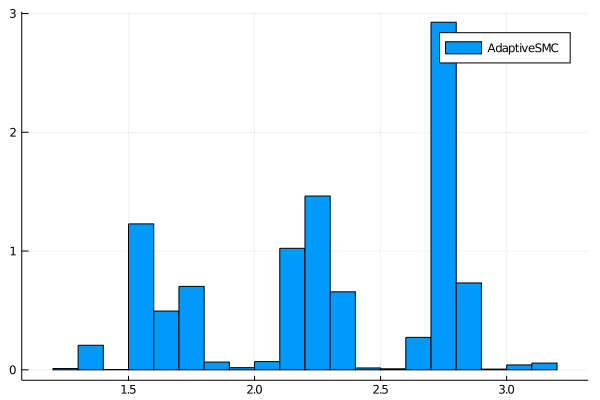

In [15]:
model_iid_onevec(x) = vcat([model(x) for _ in 1:4]...)
smc = AdaptiveSMC(prior = prior, K = 10^4)
result = run!(smc, model_iid_onevec, data_onevec, verbose = true, maxfevals = 10^6);
histogram(vcat(particles(smc)...), weights = weights(smc), normalize = true, label = "AdaptiveSMC")

Alternatively, we use another distance function:

 iteration       elapsed   fevals  epsilon      ess
         0     0 seconds    10000      Inf        1
         1      1 second    19000 1.703027e+01 0.8999999999999997
         2      1 second    27101 1.329775e+01 0.8101000000000007
         3      1 second    34392 1.088837e+01 0.7291000000000007
         4      1 second    40954 9.207855e+00 0.6561999999999998
         5      1 second    46860 7.772151e+00   0.5906
         6      1 second    52176 6.668193e+00   0.5316
Resampling...
         7     2 seconds    62176 5.818190e+00 0.9999999999999998
         8     2 seconds    71177 5.073626e+00   0.9001
         9     2 seconds    79278 4.414712e+00 0.8101000000000007
        10     2 seconds    86569 3.771912e+00 0.7291000000000007
        11     2 seconds    93131 3.236197e+00 0.6561999999999996
        12     2 seconds    99037 2.772909e+00   0.5906
        13     3 seconds   104353 2.373817e+00   0.5316
Resampling...
        14     3 seconds   114353 2.037805e+00 0.99999999999

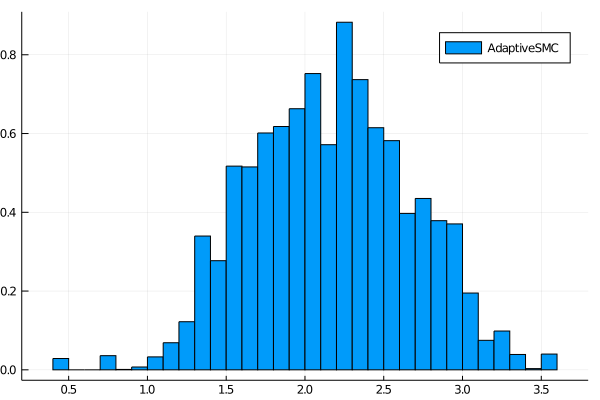

In [16]:
model_iid(x) = [model(x) for _ in 1:4]
smc = AdaptiveSMC(prior = prior, K = 10^4, distance = energydistance)
result = run!(smc, model_iid, data_iid, verbose = true, maxfevals = 10^6);
histogram(vcat(particles(smc)...), weights = weights(smc), normalize = true, label = "AdaptiveSMC")

---

*This notebook was generated using [Literate.jl](https://github.com/fredrikekre/Literate.jl).*